In [3]:
%matplotlib inline
import theano
import pymc3 as pm
import sklearn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from warnings import filterwarnings
filterwarnings('ignore')
sns.set_style('white')
from sklearn import datasets
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

In [6]:
X, Y = make_moons(noise=0.2, random_state=0, n_samples=1000)
X = scale(X)
X = X.astype(float)
Y = Y.astype(float)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.5)

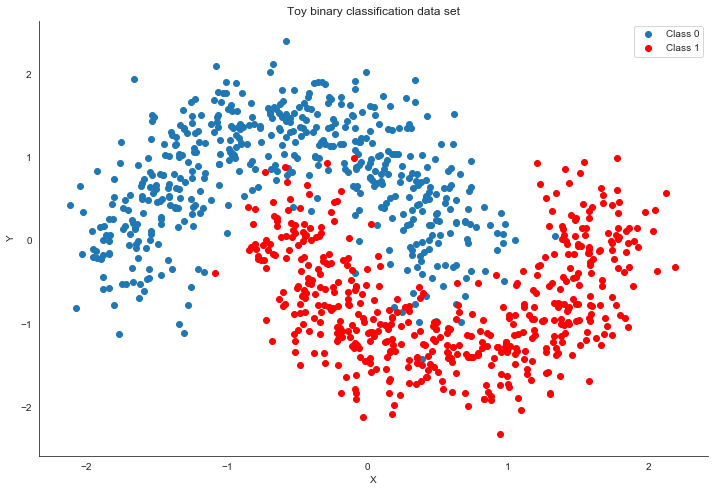

In [7]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.scatter(X[Y==0, 0], X[Y==0, 1], label='Class 0')
ax.scatter(X[Y==1, 0], X[Y==1, 1], color='r', label='Class 1')
sns.despine(); ax.legend()
ax.set(xlabel='X', ylabel='Y', title='Toy binary classification data set');

In [9]:
def construct_nn(ann_input, ann_output):
    n_hidden = 5
    
    # Initialize random weights between each layer
    init_1 = np.random.randn(X.shape[1], n_hidden).astype(float)
    init_2 = np.random.randn(n_hidden, n_hidden).astype(float)
    init_out = np.random.randn(n_hidden).astype(float)
        
    with pm.Model() as neural_network:
        # Weights from input to hidden layer
        weights_in_1 = pm.Normal('w_in_1', 0, sd=1, 
                                 shape=(X.shape[1], n_hidden), 
                                 testval=init_1)
        
        # Weights from 1st to 2nd layer
        weights_1_2 = pm.Normal('w_1_2', 0, sd=1, 
                                shape=(n_hidden, n_hidden), 
                                testval=init_2)
        
        # Weights from hidden layer to output
        weights_2_out = pm.Normal('w_2_out', 0, sd=1, 
                                  shape=(n_hidden,), 
                                  testval=init_out)
        
        # Build neural-network using tanh activation function
        act_1 = pm.math.tanh(pm.math.dot(ann_input, 
                                         weights_in_1))
        act_2 = pm.math.tanh(pm.math.dot(act_1, 
                                         weights_1_2))
        act_out = pm.math.sigmoid(pm.math.dot(act_2, 
                                              weights_2_out))
        
        # Binary classification -> Bernoulli likelihood
        out = pm.Bernoulli('out', 
                           act_out,
                           observed=ann_output,
                           total_size=Y_train.shape[0] # IMPORTANT for minibatches
                          )
    return neural_network

# Trick: Turn inputs and outputs into shared variables. 
# It's still the same thing, but we can later change the values of the shared variable 
# (to switch in the test-data later) and pymc3 will just use the new data. 
# Kind-of like a pointer we can redirect.
# For more info, see: http://deeplearning.net/software/theano/library/compile/shared.html
ann_input = theano.shared(X_train)
ann_output = theano.shared(Y_train)
neural_network = construct_nn(ann_input, ann_output)

In [10]:
from pymc3.theanof import set_tt_rng, MRG_RandomStreams
set_tt_rng(MRG_RandomStreams(42))

In [15]:
%%time

with neural_network:
    inference = pm.ADVI()
    approx = pm.fit(n=100, method=inference)

Finished [100%]: Average Loss = 397.5


Wall time: 22.4 s


In [16]:
trace = approx.sample(draws=100)

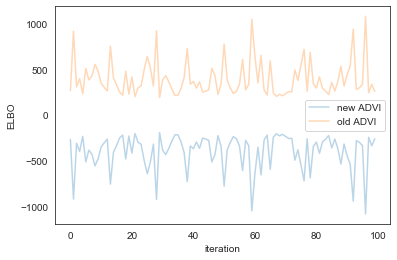

In [21]:
plt.plot(-inference.hist, label="new ADVI", alpha=0.3)
plt.plot(approx.hist, label="old ADVI", alpha=0.3)
plt.legend()
plt.ylabel("ELBO")
plt.xlabel("iteration");

In [19]:
# Replace arrays our NN references with the test data
ann_input.set_value(X_test)
ann_output.set_value(Y_test)

with neural_network:
    ppc = pm.sample_ppc(trace, samples=500, progressbar=False)

# Use probability of > 0.5 to assume prediction of class 1
pred = ppc['out'].mean(axis=0) > 0.5

AttributeError: module 'pymc3' has no attribute 'sample_ppc'

NameError: name 'pred' is not defined

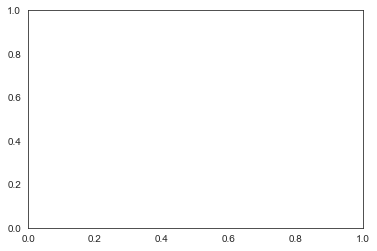

In [20]:
fig, ax = plt.subplots()
ax.scatter(X_test[pred==0, 0], X_test[pred==0, 1])
ax.scatter(X_test[pred==1, 0], X_test[pred==1, 1], color='r')
sns.despine()
ax.set(title='Predicted labels in testing set', xlabel='X', ylabel='Y');